In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import geopy

In [2]:
hop = pd.read_csv('puzzle.csv', header=None)
hop.columns = ['A','B']

## First look at data set (Exploratory Data Analysis)

In [3]:
hop.describe()

,A,B
count,1024.000000,1024.000000
mean,0.504729,-0.388165
std,0.355107,1.499346
min,-0.925070,-2.837888
25%,0.389721,-1.559228
50%,0.591392,-1.129903
75%,0.746583,0.578621
max,1.195399,3.096964


The values for both columns are roughly centered around 0; noting the min and max, they don't deviate much from 0. The data could be fluctuations in prices in plate tikets or a particular stock.

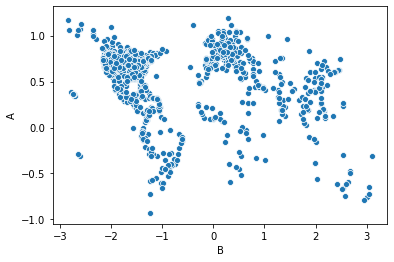

In [4]:
sns.scatterplot(data=hop, x=hop.B, y=hop.A)

The second attempt at a scatterplot reveals what appears to be points placed on continents. (I tried x=hop.A, y=hop.B before realizing this)

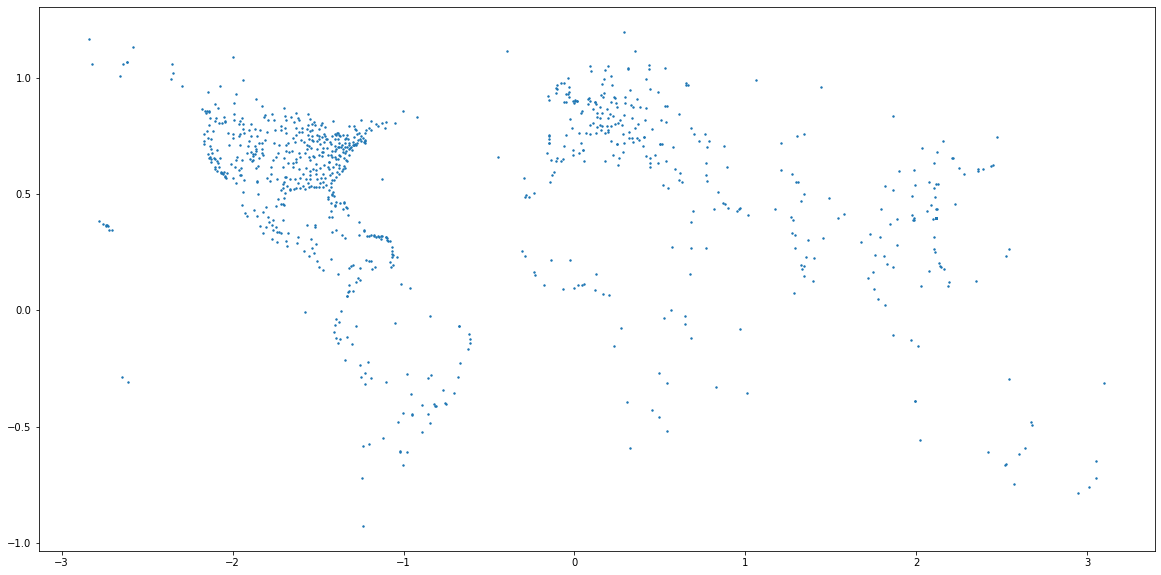

In [5]:
plt.figure(figsize=(20,10))
plt.scatter(hop.B, hop.A, s=2)

A bigger scatter plot with smaller points shows the shapes of continents and islands much more clearly. We shall try to place these on a geographical map. To facilitate this, we need the data points in latitude and logitude format. However, the data points are clearly not in this format. Upon exploration, we find that the data points are in radians and we merely need to convert them to degrees.

In [98]:
# Construct a data frame with latitude and longitude, then plot the points.
lgt = np.degrees(np.array(hop.B.tolist())) #horizontal
ltd = np.degrees(np.array(hop.A.tolist())) #vertical
hop_deg = {
    "latitude":pd.Series(ltd),
    "longitude":pd.Series(lgt)
}
hop_deg = pd.DataFrame(hop_deg)

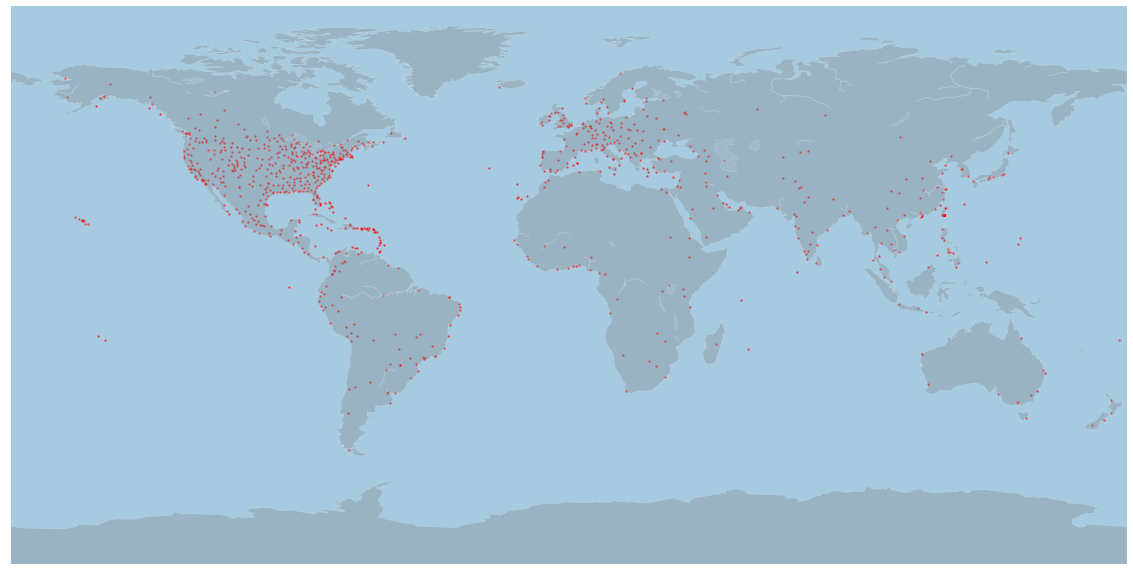

In [99]:
fig, ax = plt.subplots(figsize=(20,20))
earth = Basemap(ax=ax, projection='cyl')
earth.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
earth.fillcontinents(color='grey', alpha=0.3)
earth.drawcoastlines(linewidth=0.1, color="white")

ax.scatter(hop_deg.longitude, hop_deg.latitude,c='red', alpha=0.5, s=2)

All the points are located on land masses. It is possible that the points represent locations from where queries were made to the Hopper servers during a particular time frame. Alternatively, they could represent instances of flight destinations. With limited information about them, we now set out to try to describe the distribution of the data points. To do so, we look both at the full data set, as well as a subset of the data set containing only the points which are duplicates.

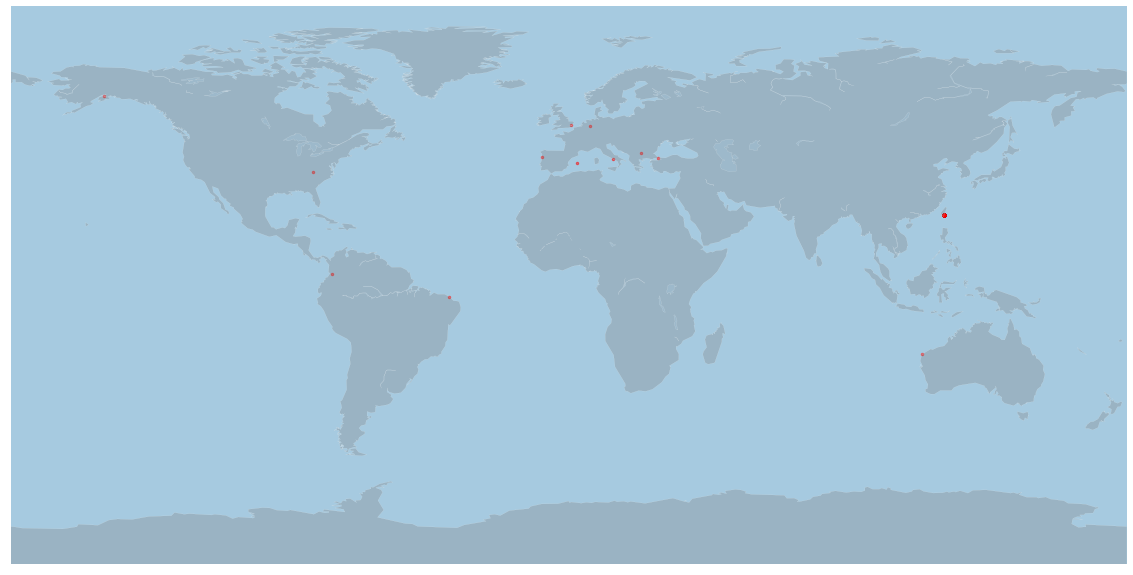

In [164]:
# Now make a data frame containing the duplicates and visualize it
duplicates = hop_deg[hop_deg.duplicated()].reset_index(drop=True)
fig, ax = plt.subplots(figsize=(20,20))
earth = Basemap(ax=ax, projection='cyl')
earth.drawmapboundary(fill_color='#A6CAE0', linewidth=0)
earth.fillcontinents(color='grey', alpha=0.3)
earth.drawcoastlines(linewidth=0.1, color="white")

ax.scatter(duplicates.longitude, duplicates.latitude,c='red', alpha=0.5, s=6)

Already we can see that there is a poin in the Taiwan island that looks particularly big. 
Having obtained only the duplicates, I proceed to describe the distribution of these geographical locations. I use the library reverse_geocoder to obtain location information from the coordinates.
## Reverse Geocoding

In [166]:
import reverse_geocoder as rg
# First construct tuples of coordinates as required by reverse_geocoder, then run them through to obtain the locations
coords = tuple(map(tuple, np.array([(ltd[i], lgt[i]) for i in range(len(ltd))])))
locations = rg.search(coords)
dup_coords= tuple(map(tuple, np.array([(duplicates.latitude.tolist()[i], duplicates.longitude.tolist()[i]) for i in range(len(duplicates))])))
dup_locations = rg.search(dup_coords)
# Next, construct pandas data frames with this information for ease of plotting.
geo = {
    "latitude":pd.Series(ltd),
    "longitude":pd.Series(lgt),
    "place":pd.Series([locations[x]['name'] for x in range(len(locations))]),
    "region":pd.Series([locations[x]['admin1'] for x in range(len(locations))]),
    "country":pd.Series([locations[x]['cc'] for x in range(len(locations))]),
}
geodf = pd.DataFrame(geo)
geo_d = {
    "latitude":duplicates.latitude,
    "longitude":duplicates.longitude,
    "place":pd.Series([dup_locations[x]['name'] for x in range(len(dup_locations))]),
    "region":pd.Series([dup_locations[x]['admin1'] for x in range(len(dup_locations))]),
    "country":pd.Series([dup_locations[x]['cc'] for x in range(len(dup_locations))]),
}
geo_d = pd.DataFrame(geo_d)

# Visualizing Frequencies
## (1) Full data set
### Plotting the counts for country to observe the frequency of occurrence.

,index,country
0,US,365
1,TW,104
2,MX,36
3,CA,36
4,BR,25


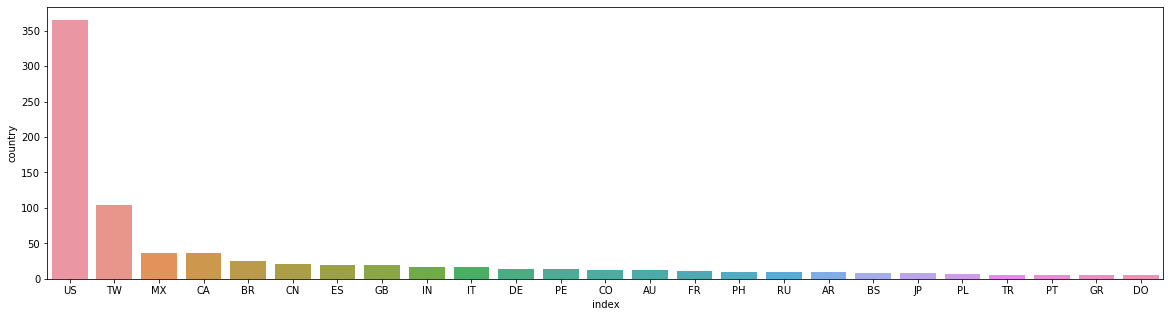

In [171]:
plot_data = pd.DataFrame(geodf['country'].value_counts()[:25].reset_index())
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(x='index', y='country', data=plot_data, ax=ax)
plt.setp(ax.get_xticklabels(), fontsize=10)
plot_data.head()

The highest incidence happens in the US. Taiwan has less than a third of the occurrences that the US has. Mexico seems to have about a sixths of the occurrences the US has. 

### Plotting the top 25 places with highest frequencies

,index,place
0,Taitung City,101
1,Spurgeon,2
2,Palmira,2
3,Augusta,2
4,Bahcelievler,2


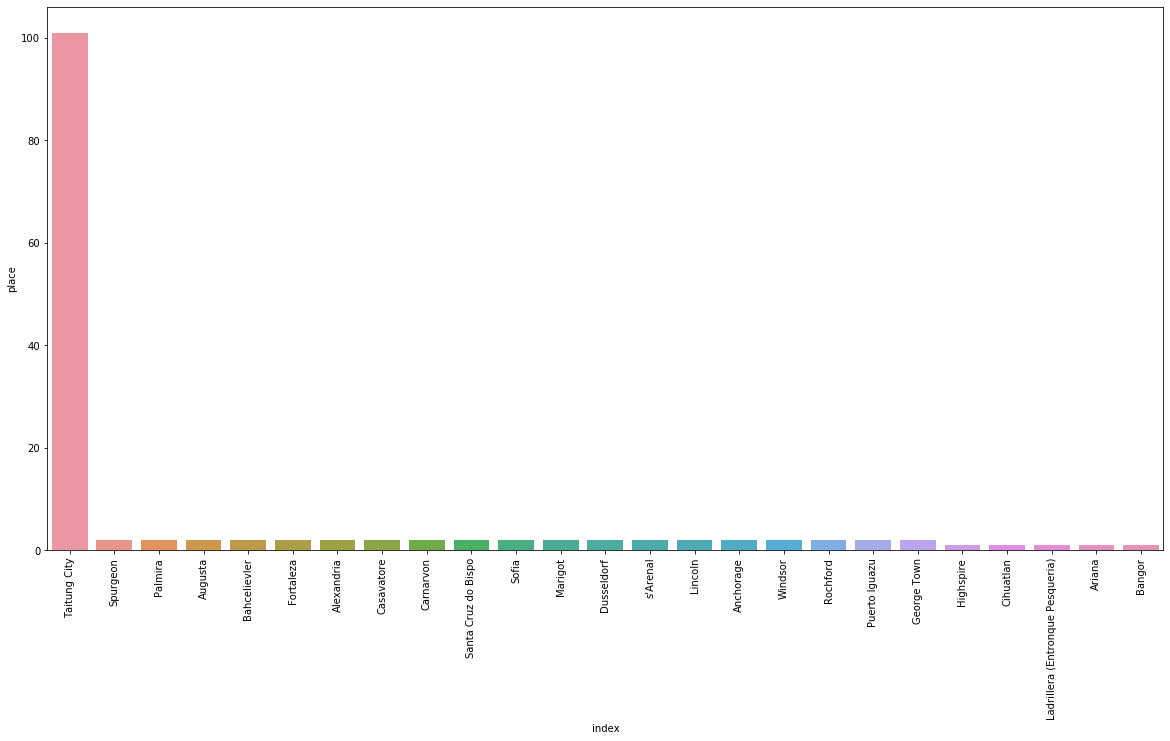

In [172]:
plot_data = pd.DataFrame(geodf['place'].value_counts()[:25].reset_index())
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x='index', y='place', data=plot_data, ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90, fontsize=10)
plot_data.head()

Even though the US has the highest frequency if we aggregate the data by country, the city of Taitung in Taiwan has by far the highest frequency of any city. Any subsequent city is dwarfed in comparison.

## (2) Data set of duplicates
### Plotting the frequency of duplicates

Now we look at the instances where the exact same coordinates where found to occur more than once in the original data set.

,index,country
0,TW,100
1,US,2
2,GB,1
3,BR,1
4,AU,1


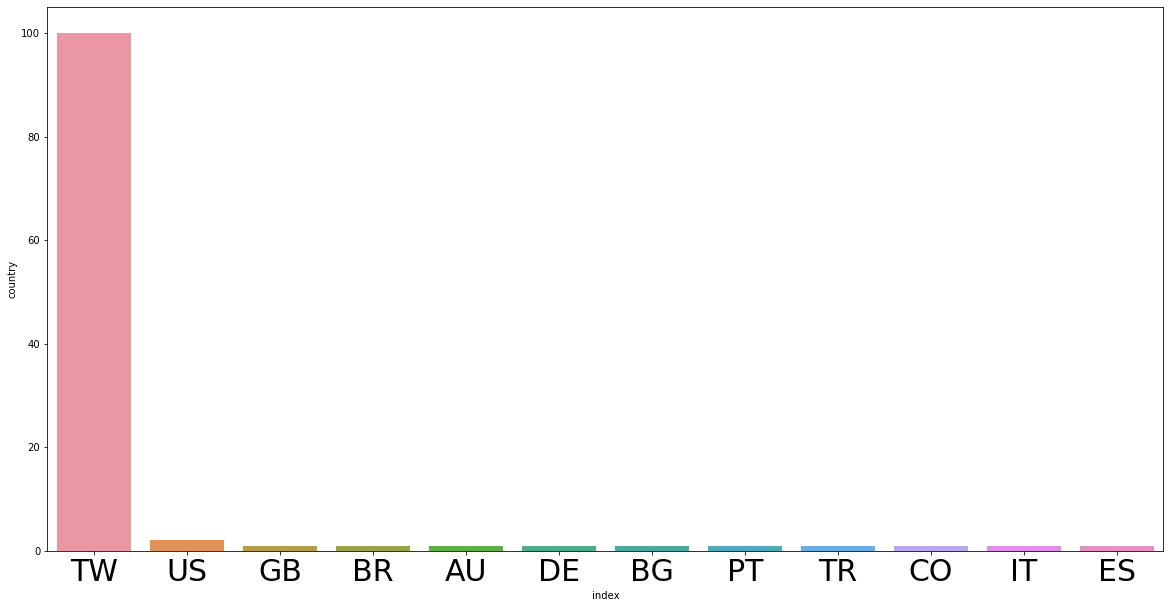

In [173]:
plot_data = pd.DataFrame(geo_d['country'].value_counts().reset_index())
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x='index', y='country', data=plot_data, ax=ax)
plt.setp(ax.get_xticklabels(), fontsize=30)
plot_data.head()

This graph shows that whatever it is that the data set is counting, occurred at the exact same coordinates in the country of Taiwan much more than in other country. 

,index,place
0,Taitung City,100
1,Anchorage,1
2,Spurgeon,1
3,Sofia,1
4,Casavatore,1


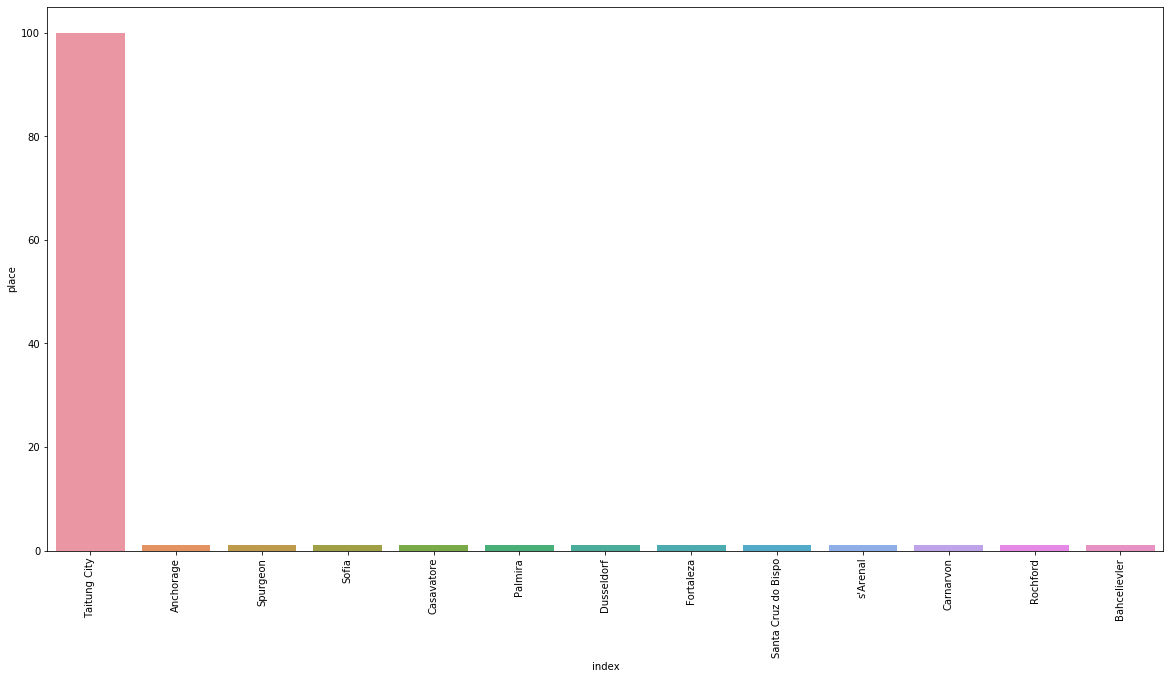

In [174]:
plot_data = pd.DataFrame(geo_d['place'].value_counts().reset_index())
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x='index', y='place', data=plot_data, ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90, fontsize=10)
plot_data.head()

This graph shows that whatever it is that the data set is counting, occurred at the exact same coordinates in the city of Taitung, Taiwan, much more than in other country. 

## Further Exploration

The coordinates that repeat that point to Taitung City are (22.755002, 121.101998), which a quick google search reveals they point directly to Taitung Airport. Upon discovering this, spending a couple minutes googling different coordinates revealed that they are all locations of airports. Further investigation reveals that the repeated coordinates do not point to the busiest airport of each region. 

In [202]:
geod_u = geo_d.drop_duplicates()
geod_u

,latitude,longitude,place,region,country
0,22.755002,121.101998,Taitung City,Taiwan,TW
7,-22.235598,114.088995,Carnarvon,Western Australia,AU
101,61.174400,-149.996002,Anchorage,Alaska,US
102,40.976899,28.814598,Bahcelievler,Istanbul,TR
103,51.289503,6.766781,Dusseldorf,North Rhine-Westphalia,DE
104,36.475198,-82.407402,Spurgeon,Tennessee,US
105,3.543223,-76.381600,Palmira,Valle del Cauca,CO
106,42.696695,23.411434,Sofia,Sofia-Capital,BG
107,40.885999,14.290799,Casavatore,Campania,IT
108,41.248103,-8.681388,Santa Cruz do Bispo,Porto,PT


Above are the unique entries for the repeated entries. None of these is the busiest aiport of its region. Some of them are very small when compared to the busiest airport of the region. The one in Istanbul doesn't service commercial flights anymore (as of 2019). This suggests that either the data is a few years old, or that it doesn't only contain airports that service commercial flights.

In [118]:
geodf[geodf.region == 'California']

,latitude,longitude,place,region,country
130,33.942501,-118.407997,El Segundo,California,US
136,37.618999,-122.375002,Millbrae,California,US
151,32.733600,-117.190003,San Diego,California,US
165,33.675703,-117.867995,Irvine,California,US
168,37.362601,-121.929000,Santa Clara,California,US
174,38.695398,-121.591006,Elverta,California,US
176,37.721301,-122.221002,Alameda,California,US
187,33.128299,-117.279997,Lake San Marcos,California,US
191,34.055998,-117.600997,Ontario,California,US
195,33.817699,-118.151999,Signal Hill,California,US


In [210]:
len(hop.drop_duplicates())

912

In [214]:
len(geodf[geodf.country == 'US'].drop_duplicates())

363

The data set, however, does not only contain entries for secondary airports or airports that aren't the busiest. And a quick look at how many unique coordinates there are reveals that it also doesn't contain an entry for every international airport as of 2020 (about 1200). It also doesn't contain an entry for every commercial airport there is in the US (about 500), but it contains more unique entries than the number of international airports there is in the US (about 150).

# Conclusions

I propose that the data could have been obtained from three possible scenarios. All three involve data taken during a particular time window (e.g. 30 mins or an hour). 
## Possibility 1
It is possible that the data points are the coordinates for results for searches made with the Hopper.

According to Wikipedia, Taitung is one of the major cities on the east coast of the island. The city is served by Taitung Airport. Taitung is a gateway to Green Island and Orchid Island, both of which are popular tourist destinations. Therefore, the data might have been recorded before an upcoming Taiwanese holiday when people became interested in traveling to these islands passing through Taitung.
## Possibility 2
The search results might be hits for the cheapest flight for flying to a particular territory (e.i. the cheapest airport to arrive at a particular state in the US, small country, etc.). However, a quick search for flights from Japan to Taiwan with my phone using the Hopper app (which I use regularly to book my flights) reveals that it is cheaper to fly to Taipei instead of to Taitung when going to Taiwan. This undermines this possibility since the airport with the highest frequency in the data set is the Taitung airport. 

## Possibility 3
It is also likely that the data points aren't destinations but points of departure. It is possible that there is a coordinate entry for every search made using Hopper inquiring for flights departing from each entry recorded. In this case, the entries don't communicate any information about ticket fares, but rather where there is interest/potential demand for tickets.